In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from scipy.optimize import minimize
from scipy.signal import argrelmin

In [2]:
T = 0.03
beta = 1/T

# The discretized values of omega
omega = np.linspace(-10, 10, 100000, dtype = complex)

# The Matsubara frequencies
max_freq = 3
n_freq = int(((max_freq * beta / np.pi) - 1) / 2) + 1
matsu_freq = (2 * np.array(range(-n_freq, n_freq), dtype = complex) + 1) * np.pi / beta

# The small delta
delta = 1e-3

In [3]:
# Plots complex array by showing real and imaginary parts
def plot_complex(a, title, is_matsu = True):
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(title)
    if is_matsu:
        ax[0].plot(np.real(matsu_freq), np.real(a))
        ax[1].plot(np.real(matsu_freq), np.imag(a))
        #ax[1].plot(np.real(matsu_freq), - 1 / np.real(matsu_freq))
        #ax[1].set_ylim(-3, 3)
    else:
        ax[0].plot(np.real(omega), np.real(a))
        ax[1].plot(np.real(omega), np.imag(a))
    ax[0].set_title("Real Part")
    ax[1].set_title("Imaginary Part")

We retrieve the parameters $\{V_k, \epsilon_k\}_k$ of the Anderson impurity model from the hybridization function:

$$\Delta(\omega) = \sum_k \frac{V_k^2}{\omega - \epsilon_k + i\delta}$$

We place ourselves at half-filling so that $\mu = \frac U2$, and the AIM hamiltonian reads:

$$H = U n_\uparrow n_\downarrow - \frac U 2 (n_\uparrow + n_\downarrow) + \sum_{k,\sigma} \epsilon_k a_{k,\sigma}^\dagger a_{k,\sigma} + \sum_{k,\sigma} V_k (a_{k,\sigma}^\dagger c_\sigma + c_\sigma^\dagger a_{k,\sigma})$$

where $a_{k,\sigma}^\dagger$ denotes the creation operator of an electron in the bath, $c_\sigma^\dagger$ denotes the creation operator of the impurity electron and $n_\sigma = c_\sigma^\dagger c_\sigma$.

### Retrieval of the hamiltonian parameters

$\Delta(\omega)$ is represented as an array of complex numbers corresponding to different values of $\omega$. We recover the hamiltonian parameters $\{V_k, \epsilon_k\}_k$ by optimizing a function:

$$f : \{V_k, \epsilon_k\}_k \to \Delta(\omega) $$

against the real $\Delta(\omega)$.

To obtain an initial guess, we use the fact that the local minima of $\Im (\Delta(\omega))$ are the $\epsilon_k$ and that close to $\epsilon_k$, its contribution will dominate so that:

$$V_k^2 \approx - \delta \Im (\Delta(\epsilon_k))$$

In [4]:
# Retrieval of hamiltonian parameters from the hybridization function with Matsubara frequencies

def matsuHybridizationFunction(V, e):
    n = len(V)
    s = matsu_freq * 0
    for k in range(n):
        s += V[k]**2 / (1.j * matsu_freq - e[k])
    return s

def matsuHamParameters(matsu_hyb_func, n_k):
    
    # The format of the argument of matsu_optimize_me is V_i, e_i
    def matsu_optimize_me(args):
        n = len(args)
        V = args[:n//2]
        e = args[n//2:]
        return np.linalg.norm(matsu_hyb_func - matsuHybridizationFunction(V, e)) ** 2
    
    args_ini = np.zeros(2 * n_k)
    
    # minimize matsu_optimize_me
    res = minimize(matsu_optimize_me, args_ini, method = 'Powell', tol = 1e-10)
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [5]:
# Check that it works properly

n_k = 3
V = [3.6, 2.3, 8.1]
e = [-2.1, 1.1, -3.1]

matsu_hyb_func = matsuHybridizationFunction(V, e)
matsuHamParameters(matsu_hyb_func, n_k)

(array([1.76368158, 8.6601146 , 2.28879293]),
 array([-1.61659119, -2.95261278,  1.09233598]),
 0.003939311549592378)

# Constructing the hamiltonian

Using the hamiltonian parameters $\{V_k, \epsilon_k\}_k$, we can now construct the hamiltonian. We use the following convention indexing the sites with $i$:
- If $i$ is even, the site has spin up
- If $i$ is odd, the site has spin down
- $i//2 = 0$ indicates the impurity site
- $i//2 = k > 0$ indicates site k - 1

For example 100100 indicates that the spin up impurity site and the spin down first bath level are filled.

Creation operator are ordered with the smallest index on the left:

$$ |100100\rangle = a_\uparrow^\dagger c_{1, \downarrow}^\dagger |000000\rangle = c_1^\dagger c_4^\dagger |000000\rangle$$

### Change sign with ordering of operator

With fermionic system, a state is defined with a conventional ordering of fermionic operators. For example:

$$ | 1001 \rangle = c_1^\dagger c_4^\dagger | 0 \rangle = - c_4^\dagger c_1^\dagger | 0 \rangle $$
$$ | 1110 \rangle = c_1^\dagger c_2^\dagger c_3^\dagger | 0 \rangle $$

The Hamiltonian should reflect this because `create` and `destroy` do not have the good anticommutation relations.

Defining $c_k^\dagger = \bigotimes_{j < k} \sigma_j^z \otimes \sigma_k^+$ ensures the correct anticommutation relations.

In [6]:
def AIM(V, e, U):
    
    # Number of sites in the bath
    nk = len(V)
    
    # Total number of sites
    n = 2 * (nk + 1)
    
    # Defines the fermionic creation operators
    cdags = []
    for k in range(n):
        prod = [sigmaz() for x in range(k)] + [create(2)] + [qeye(2) for x in range(n - k - 1)]
        cdags.append(tensor(prod))
    
    # Impurity on-site interaction
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    prod[1] = num(2)
    H1 = U * tensor(prod)
    
    # Impurity chemical potential
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    H2 = - (U/2) * tensor(prod)
    prod = [qeye(2) for x in range(n)]
    prod[1] = num(2)
    H2 += - (U/2) * tensor(prod)
    
    # Bath energy levels
    H3 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            prod = [qeye(2) for x in range(n)]
            prod[2*(k + 1) + spin] = num(2)
            H3 += e[k] * tensor(prod)
    
    # Bath-impurity interaction
    H4 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            
            H4 += V[k] * cdags[2*(k + 1) + spin] * cdags[spin].dag()
            
            H4 += V[k] * cdags[spin] * cdags[2*(k + 1) + spin].dag()
            
    return H1 + H2 + H3 + H4

##### An example to check that the hamiltonian is correct

In [7]:
H = AIM([2, 2], [3, -3], 1)
H

Quantum object: dims = [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0. -3.  0. ...  0.  0.  0.]
 [ 0.  0. -3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  3.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

In [8]:
H[int('100000', 2), int('100000', 2)]

(-0.5+0j)

### Impurity Green's function

We compute the diagonal element of the Green's function corresponding to the impurity spin up site in frequency space.

$$ G(\omega) = \frac{1}{Z} \sum_{n,n'} \frac{|\langle n' | c_\uparrow^\dagger | n \rangle|^2}{\omega + E_n - E_{n'} + i\delta} \left( e^{-\beta E_n} + e^{-\beta E_{n'}} \right) $$

$$ G(i \omega_k) = \frac{1}{Z} \sum_{n,n'} \frac{|\langle n' | c_\uparrow^\dagger | n \rangle|^2}{i \omega_k + E_n - E_{n'}} \left( e^{-\beta E_n} + e^{-\beta E_{n'}} \right) $$

In [9]:
# Returns the spin up impurity green's function given the hamiltonian

def impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0
            
            prob = abs((ei.H @ ej)[0,0])**2
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (omega + eigvals[j] - eigvals[i] + 1.j * delta)
    
    return G / Z

In [10]:
# Returns the spin up impurity green's function with Matsubara frequencies given the hamiltonian

def matsu_impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            # No anticommutation problem because we consider the first site
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0                
            
            prob = abs((ei.H @ ej)[0,0])**2
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])
    
    return G / Z

### Computing Green's function with the Lanczos algorithm

##### At zero temperature

- Compute the ground state
- Obtain the Lanczos coefficients starting from the ground state

In [315]:
# Performs m iteration of the Lanczos algorithm on H with initial vector x

def Lanczos(H, x, m):
    
    lx = [0 * x, x]
    a = []
    b = [0]
    
    for k in range(m - 1):
        
        y = H * lx[-1]
        a.append((lx[-1].dag() * y).tr())
        y = y - a[-1] * lx[-1] - b[-1] * lx[-2]
        b.append(y.norm())
        lx.append(y / b[-1])
        
        # Warn in case b becomes small
        if b[-1] < 1e-5:
            print(r"Warning: Small b")

    y = H * lx[-1]
    a.append((lx[-1].dag() * y).tr())
    
    del lx[0]
    
    return lx, a, b

In [316]:
# Recompose the matrices T and U from the output of Lanczos such that H = U * T * U^dag

def Lanczos_recompose(lx, a, b):
    
    m = len(a)
    n = lx[0].shape[0]
    
    T = np.zeros((m,m), dtype = complex)
    U = np.zeros((n,m), dtype = complex)

    for k in range(m - 1):
        T[k,k] = a[k]
        T[k, k + 1] = b[k + 1]
        T[k + 1, k] = b[k + 1]
    T[-1, -1] = a[-1]

    for k in range(m):
        U[:,k] = np.array(lx[k]).flatten()

    return Qobj(T), Qobj(U)

In [323]:
# A test with one bath site

M = AIM([2], [3], 1)
M.dims = [[16],[16]]

x0 = Qobj(np.random.rand(16))
x0 = x0 / x0.norm()

lx, a, b = Lanczos(M, x0, 10)

T, U = Lanczos_recompose(lx, a, b)

Teigs, Tvecs = np.linalg.eigh(T._data.todense())
Meigs, Mvecs = np.linalg.eigh(M._data.todense())

print(Teigs)
print(Meigs)

[-2.16852058e+00 -1.40753645e+00  1.20816237e-15  1.89150472e+00
  2.50000000e+00  2.82041335e+00  3.90753645e+00  6.00000000e+00
  6.60849528e+00  7.84810723e+00]
[-2.16852058 -1.40753645 -1.40753645  0.          1.89150472  1.89150472
  2.5         2.5         2.5         2.82041335  3.90753645  3.90753645
  6.          6.60849528  6.60849528  7.84810723]


In [505]:
# Returns the spin up impurity green's function given the hamiltonian using the Lanczos algorithm

# m1 is the number of Lanczos iteration for the first step and m2 for the second

# TO BEGIN WE ASSUME THAT THE TEMPERATURE IS LOW ENOUGH THAT WE CAN NEGLECT ALL TERMS DIFFERENT FROM THE GROUND STATE

def Lanczos_green(H, T, m1, m2):
    
    # Compute the ground state
    n = H.shape[0]
    x0 = Qobj(np.random.rand(n))
    x0 = x0 / x0.norm()
    
    lx, a, b = Lanczos(H, x0, m1)
    T, U = Lanczos_recompose(lx, a, b)
    
    Teigs, Tvecs = np.linalg.eigh(T._data.todense())
    
    for i in range(m1):
        for j in range(i + 1, m1):
            print((lx[i].dag() * lx[j]).tr())
    
    print(b)
    
    return Teigs[0], U * Qobj(Tvecs[:,0])

    # Second Lanczos starting from GS
    # ...

In [506]:
# Test

H = AIM([2,2], [3,-3], 1)
n1,n2 = H.shape
H.dims = [[n1],[n2]]

TE0, TGS = Lanczos_green(H, 0.1, 20, 'hello')
TGS = TGS / TGS.norm()

Heigs, Hvecs = np.linalg.eigh(H._data.todense())
E0, GS = Heigs[0], Qobj(Hvecs[:,0])
GS = GS / GS.norm()

print("Lanczos ground energy: {:.4}".format(TE0))
print("True ground energy:    {:.4}".format(E0))
print("\n|TGS - GS|: {:.4}".format(min((TGS - GS).norm(), (TGS + GS).norm())))
print("\n\nTGS: " + str(TGS))
print("\nGS: " + str(GS))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6521711082573276e-11
6.470482569881364e-12
-1.916984129757531e-08
-0.002350788769928757
-0.05606660318398549
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1976737996334205e-11
1.4382726671972879e-11
-2.3033950183955383e-10
-2.850535680538706e-09
-0.08410081977201188
-0.11229233829967743
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.099337201132533e-12
0.0
-3.88086192956022e-11
-2.2916042978146645e-11
-4.738292181348785e-08
-0.021772612386377694
-0.1552905671797651
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.520230639861301e-12
0.0
-1.6212950865743606e-10
-1.5595846089142462e-08
-0.05891545487174841
-0.12165684761233875
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.7933050080105e-12
0.0
-1.1075950139688429e-10
-4.777402270550284e-09
-0.048182875541577116
-0.061887275329220115
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.709102899291828e-12
4.734919959370129e-11
-2.2332258351603906e-10
1.0176294269054198e-09
-2.380814091239693e-07
0.3926072388429781

In [464]:
TGS

Quantum object: dims = [[64], [1]], shape = (64, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.58987693e-12]
 [ 0.00000000e+00]
 [ 7.81348033e-12]
 [ 0.00000000e+00]
 [-3.67225117e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.57743374e-01]
 [-1.81036741e-12]
 [ 5.73275518e-02]
 [-2.46253348e-02]
 [ 1.86726803e-12]
 [ 0.00000000e+00]
 [ 2.52191583e-12]
 [ 0.00000000e+00]
 [ 7.08072718e-01]
 [ 5.44200410e-12]
 [ 0.00000000e+00]
 [ 1.05158809e-01]
 [ 0.00000000e+00]
 [-1.31858894e-12]
 [ 1.05158809e-01]
 [-9.03429779e-02]
 [ 0.00000000e+00]
 [-1.62925947e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.32065547e-11]
 [ 0.00000000e+00]
 [ 1.52156749e-12]
 [ 0.00000000e+00]
 [-3.04156155e-01]
 [ 0.00000000e+00]
 [-2.10317617e-01]
 [ 4.51714890e-02]
 [-1.05082995e-12]
 [ 0.00000000e+00]
 [ 4.51714890e-02]
 [ 0.00000000e+00]
 [ 3.68646989e-12]
 [ 6.99856504e-03]
 [ 0.00000000e+00]
 [ 8.01614876e-12]
 [-3.10448781e-11]
 [ 2.2272271

In [465]:
GS

Quantum object: dims = [[64], [1]], shape = (64, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.19250561e-17]
 [-1.58089272e-16]
 [ 0.00000000e+00]
 [ 4.25945618e-16]
 [ 2.83278520e-17]
 [ 3.99662320e-01]
 [ 1.70668312e-16]
 [ 1.63064007e-16]
 [-8.32667268e-17]
 [ 9.56925444e-08]
 [ 1.11022302e-16]
 [-6.23913271e-02]
 [-1.49385732e-08]
 [-2.60208521e-18]
 [ 1.08420217e-19]
 [ 6.24839265e-17]
 [ 2.17815369e-16]
 [-7.70617184e-01]
 [ 2.62088461e-16]
 [ 0.00000000e+00]
 [-1.14447546e-01]
 [-2.58493941e-26]
 [ 3.54833232e-17]
 [-1.14447546e-01]
 [-5.48051508e-08]
 [-9.18234826e-19]
 [ 1.77317289e-02]
 [ 7.06819371e-28]
 [-1.10950334e-18]
 [ 9.86076132e-32]
 [-3.37256539e-17]
 [ 7.78807847e-17]
 [ 1.88579752e-17]
 [-1.84511562e-07]
 [ 9.24782028e-17]
 [ 2.28895092e-01]
 [ 2.74025754e-08]
 [ 8.88597614e-19]
 [-2.18702755e-18]
 [ 2.74025754e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.24556973e-09]
 [ 1.06738944e-18]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 9.7274622

# DMFT loop

We work on the Bethe lattice for a simplified loop: $\Delta(\omega) = t^2 G_\text{imp}$

In [11]:
# Returns the spin up impurity green's function given the hybridization function

def matsu_loopstep(matsu_hyb_func, n_k, U, T, verbose = False):
    print("Retrieving hamiltonian parameters")
    V, e, val = matsuHamParameters(matsu_hyb_func, n_k)
    print("Optimization MSE: {:.4}".format(val))
    print(V)
    print(e)
    H = AIM(V, e, U)
    print("Computing green's function\n")
    G = matsu_impurity_green(H, T)
    realG = impurity_green(H, T)
    return G, realG

### Initial Green's function

We start with a circular spectral function:

$$G_\text{ini}(\omega) = \frac{\omega - \text{sgn}(\omega)\sqrt{\omega^2 - 4t^2}}{2t^2}$$
or $$G_\text{ini}(i\omega_n) = \frac{i\omega_n - \text{sgn}(\omega_n)i\sqrt{\omega_n^2 + 4t^2}}{2t^2}$$

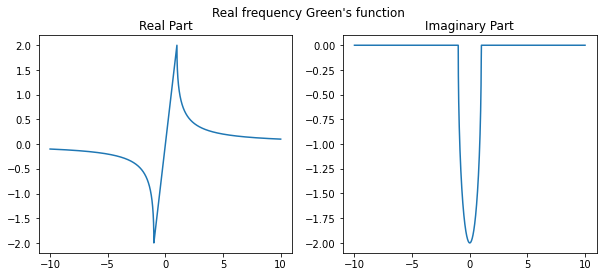

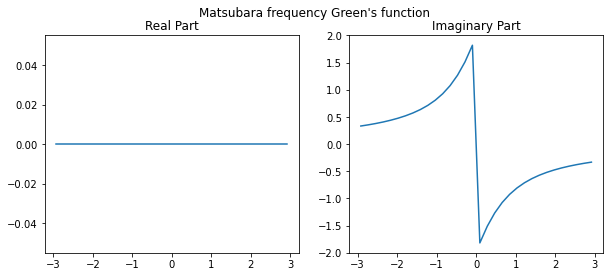

In [12]:
t = 0.5

hyb_func = (omega - np.sign(np.real(omega)) * (omega ** 2 - 4 * t ** 2) ** 0.5) / (2 * t ** 2)
plot_complex(hyb_func, "Real frequency Green's function", is_matsu = False)

matsu_hyb_func = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 4 * t ** 2) ** 0.5) / (2 * t ** 2)
plot_complex(matsu_hyb_func, "Matsubara frequency Green's function", is_matsu = True)

Step 1
Retrieving hamiltonian parameters
Optimization MSE: 0.5569
[0.61199111 0.61199115]
[-0.18304568  0.18304571]
Computing green's function

Step 2
Retrieving hamiltonian parameters
Optimization MSE: 0.3396
[0.66367587 0.66367587]
[-0.67031277  0.67031281]
Computing green's function

Step 3
Retrieving hamiltonian parameters
Optimization MSE: 0.7688
[-0.58644943 -0.45545348]
[-0.01300384  0.46052301]
Computing green's function

Step 4
Retrieving hamiltonian parameters
Optimization MSE: 0.02526
[0.71457433 0.6601536 ]
[-0.67283742  0.6013415 ]
Computing green's function

Step 5
Retrieving hamiltonian parameters
Optimization MSE: 0.7951
[-0.54663463  0.48667976]
[-0.0052143   0.48867021]
Computing green's function

Done


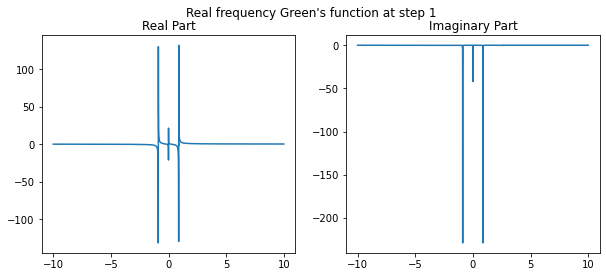

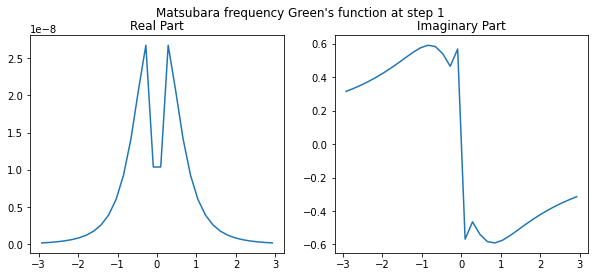

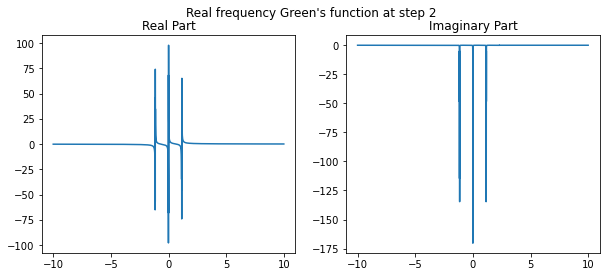

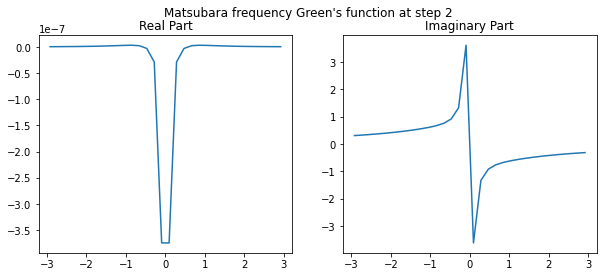

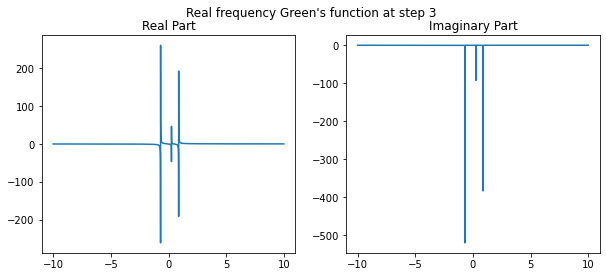

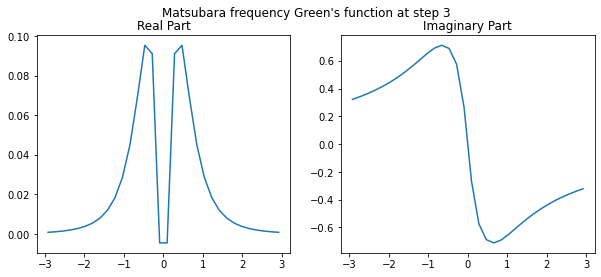

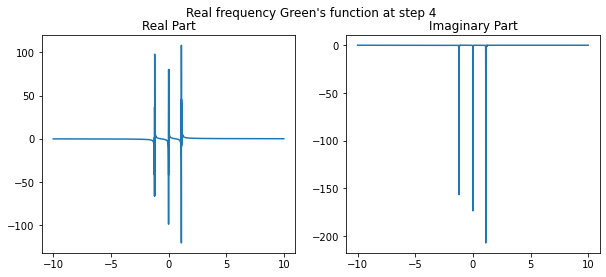

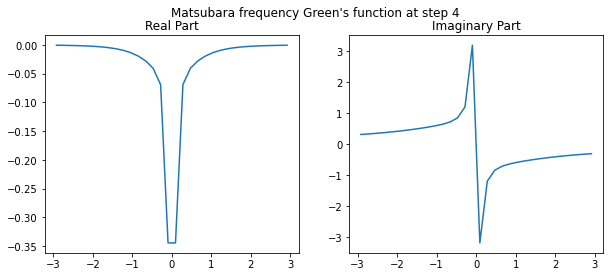

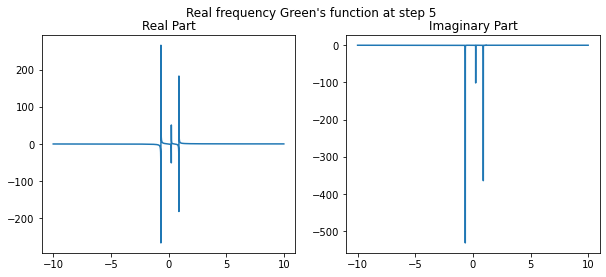

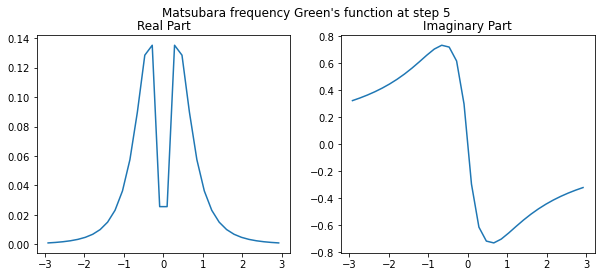

In [13]:
# In Matsubara frequency

# T was defined above
n_k = 2
U = 0.1

t = 0.5
matsu_hyb_func = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 4 * t ** 2) ** 0.5) / (2 * t ** 2)

for k in range(5):
    print("Step {}".format(k + 1))
    matsu_hyb_func, realG = matsu_loopstep(matsu_hyb_func, n_k, U, T)
    plot_complex(realG, "Real frequency Green's function at step " + str(k + 1), is_matsu = False)
    plot_complex(matsu_hyb_func, "Matsubara frequency Green's function at step " + str(k + 1), is_matsu = True)

print("Done")

### Random notes

$$ G(i\omega_n) = G^*(-i\omega_n) $$

Matsubara Green's function should have symmetric real part and antisymmetric imaginary part. Retarded Green's function should be the opposite: antisymmetric real part and symmetric imaginary part.

The extrapolation at 0 of the imaginary part of $G(i\omega_n)$ should be $A(0)$ (The value at 0 of the corresponding spectral function).

The imaginary part of $G(i\omega_n)$ should decay as $1/\omega_n$.

Every energies should be degenerated twice

Real frequency GF should have symmetric peak

# Old stuff

Real frequency loop and other old stuff that doesn't work.

In [4]:
def hybridizationFunction(V, e):
    n = len(V)
    s = omega * 0
    for k in range(n):
        s += V[k]**2 / (omega - e[k] + 1.j * delta)
    return s

def hamParameters(hyb_func, n_k, verbose = False):
    
    # The format of the argument of optimize_me is V_i, e_i
    def optimize_me(args):
        n = len(args)
        V = args[:n//2]
        e = args[n//2:]
        return np.linalg.norm(hyb_func - hybridizationFunction(V, e))
    
    # Obtain initial guess
    
    # The energies are the minimums of the imaginary part
    e_ini = np.real(omega[argrelmin(np.imag(hyb_func))])
    
    # The V_k are approximately sqrt(delta ** 2 * hyb_func(e_k)
    V_ini = np.sqrt(-delta * np.imag(hyb_func)[argrelmin(np.imag(hyb_func))[0]])
    
    args_ini = np.zeros(2 * n_k)
    args_ini[:n_k] = V_ini
    args_ini[n_k:] = e_ini
    
    if verbose:
        print(optimize_me(args_ini))
        print("\nV_ini: ")
        print(V_ini)
        print("\ne_ini: ")
        print(e_ini)
    
    # minimize optimize_me based on the initial guess
    res = minimize(optimize_me, args_ini, method = 'BFGS')
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [145]:
# Check that it works properly

n_k = 4
V = [9.3, 12.1, 2.1, 5.5]
e = [-3,-7,9,4]

hyb_func = hybridizationFunction(V, e)
hamParameters(hyb_func, n_k)

(array([12.09999559,  9.30000403,  5.4999936 ,  2.09997706]),
 array([-7.00000001, -3.        ,  4.        ,  9.00000002]),
 2.581014680362732)

In [13]:
# Returns the spin up impurity green's function given the hybridization function

def loopstep(hyb_func, n_k, U, T):
    V, e, val = hamParameters(hyb_func, n_k)
    H = AIM(V, e, U)
    G = impurity_green(H, T)
    return G

##### Wrong hamiltonian (for bosons)

In [8]:
def AIM_old(V, e, U):
    
    # Number of sites in the bath
    nk = len(V)
    
    # Total number of sites
    n = 2 * (nk + 1)
    
    # Impurity on-site interaction
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    prod[1] = num(2)
    H1 = U * tensor(prod)
    
    # Impurity chemical potential
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    H2 = - (U/2) * tensor(prod)
    prod = [qeye(2) for x in range(n)]
    prod[1] = num(2)
    H2 += - (U/2) * tensor(prod)
    
    # Bath energy levels
    H3 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            prod = [qeye(2) for x in range(n)]
            prod[2*(k + 1) + spin] = num(2)
            H3 += e[k] * tensor(prod)
    
    # Bath-impurity interaction
    H4 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            
            prod = [qeye(2) for x in range(n)]
            prod[spin] = destroy(2)
            prod[2*(k + 1) + spin] = create(2)
            H4 += V[k] * tensor(prod)
            
            prod = [qeye(2) for x in range(n)]
            prod[spin] = create(2)
            prod[2*(k + 1) + spin] = destroy(2)
            H4 += V[k] * tensor(prod)
            
    return H1 + H2 + H3 + H4